In [1]:
# TODO:
# GRAD-CAM
# data visualization DONE
# LSTM based model DONE
# standardization and normalization (either based on training or individually) DONE
# image based CNN IN PROGRESS
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import shutil
import os
import pickle
from scipy.signal import stft

In [2]:
# CNN class
# TODO: some hardcoded numbers

class CNN(nn.Module):
    def __init__(self, input_size, conv_channels=(3, 10), kernel=(5, 5), dropout=0.0):
        super().__init__()
        num_flattened = (((input_size[1] - kernel[0] + 1) // 2 - kernel[1] + 1) // 2) * (((input_size[2] - kernel[0] + 1) // 2 - kernel[1] + 1) // 2) * conv_channels[1]
        self.conv1 = nn.Conv2d(input_size[0], conv_channels[0], kernel[0])
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(conv_channels[0], conv_channels[1], kernel[1])
        self.fc1 = nn.Linear(num_flattened, 120) # 5: 58, 7: 
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)
        self.dropout1d = nn.Dropout(p=dropout)
        self.dropout2d = nn.Dropout2d(p=dropout)
        self.batchnorm1 = nn.BatchNorm2d(input_size[0])
        self.batchnorm2 = nn.BatchNorm2d(conv_channels[0])

    def forward(self, x):
        x = self.batchnorm1(x)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout2d(x)
        # print(x.shape)
        # x = self.dropout2d(x)
        x = self.batchnorm2(x)
        x = self.pool(F.relu(self.conv2(x)))
        # print(x.shape)
        # x = self.dropout2d(x)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        # print(x.shape)
        x = F.relu(self.fc1(x))
        x = self.dropout1d(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [3]:
from swec_utils import training_model
def grid_search(epochs, device, weights, train_loader, val_loader, dtype, kernel_sizes, n_filters, dropouts, save_path, plot_results=False, verbose=True):
    sensitivity = []
    specificity = []
    auc = []
    f1 = []
    pr_auc = []
    for k in kernel_sizes:
        for f in n_filters:
            for d in dropouts:
                print(f"Training model with kernel size = {k}, filter_sizes = {f}, dropout = {d}.")
                model = CNN(input_size=next(iter(train_loader))[0].shape[1:], conv_channels=f, kernel=(k, k), dropout=d)
                model.to(numpy_to_torch_dtype_dict[dtype])
                t_res, v_res = training_model(model, epochs, device, weights, train_loader, val_loader, dtype, plot_results=plot_results, verbose=verbose)
                sensitivity.append(v_res.sen[-1])
                specificity.append(v_res.spe[-1])
                auc.append(v_res.auc[-1])
                f1.append(v_res.f1[-1])
                pr_auc.append(v_res.pr_auc[-1])
                if (save_path):
                    print("Saving model")
                    save_path += 'CNN_k' + str(k) + '_f' + str(f[0]) + '_' + str(f[1]) + '_d' + str(d).replace('.', '')
                    torch.save(model.state_dict(), save_path)
    
    return sensitivity, specificity, auc, f1, pr_auc

In [4]:
from swec_utils import load_data, load_data_partitioned

# ID1: 0, 0.86
# ID2: 
# ID3: 40, 0.8
def channel_selection(X, Y, dtype, kernel_sizes, n_filters, dropouts):
    BATCH = 512
    EPOCHS = 250
    seed = 0
    results_list = []
    for channel in range(X.shape[1]):
        print(f"Channel {channel}.")
        
        use_cuda = True
        device = torch.device("cuda" if use_cuda else "cpu")
        X_train, X_val, Y_train, Y_val = train_test_split(X[:,[channel]], Y, test_size=0.2, stratify=Y, random_state=seed)

        weights = torch.tensor(compute_class_weight(class_weight='balanced', classes=np.unique(Y_train), y=Y_train), dtype=numpy_to_torch_dtype_dict[dtype], device=device)

        # convert dataset to Dataloader
        train_dataset = STFTDataset(X_train, Y_train, dtype=dtype)
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH)
        val_dataset = STFTDataset(X_val, Y_val, dtype=dtype)
        val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH)

        results = grid_search(EPOCHS, device, weights, train_loader, val_loader, dtype, kernel_sizes, n_filters, dropouts, save_path='', verbose=False)
        results_list.append(results)

    return results_list

In [5]:
def copy_subject(src, dst):
    src_files = os.listdir(src)
    for file_name in src_files:
        full_file_name = os.path.join(src, file_name)
        if os.path.isfile(full_file_name):
            shutil.copy(full_file_name, dst)
            print(file_name)

subject = 'ID03'
src = 'D:/research/swec/' + subject
dst = './swec/' + subject
data_path = './swec/' + subject + '/data.p'

if (not os.path.exists(dst)):
    os.mkdir(dst)
if (not os.path.exists(data_path)):
    if (len(os.listdir(dst)) <= 1):
        copy_subject(src, dst)

In [6]:
#  1: 4
#  2: 7
#  3: 2
#  4: not enough data
#  5: 3
#  6: 1
#  7: not enough data
#  8: 1
#  9: not enough data
# 10: not enough data
# 11: 7
# 12 
from swec_utils import load_data, load_data_partitioned
from scipy.signal import stft
subject_path = './swec/' + subject + '/' + subject
seq_duration = 5
sph = 300
pil = 3600
distance = 3600 * 24 * 0
ds = 10

nperseg = 256
dtype = np.float16

partitioned = True

if (partitioned):
    num_test_sz = 1
    tr_segments, tr_labels, ts_segments, ts_labels, fs = load_data_partitioned(subject_path, seq_duration, sph, pil, distance, channels=[], ds=ds, dtype=dtype, num_test_sz=num_test_sz)
    tr_segments_t = np.transpose(tr_segments, (0, 2, 1))
    ts_segments_t = np.transpose(ts_segments, (0, 2, 1))
    stft_size = (129, seq_duration * fs // (nperseg // 2) + 1)
    tr_Zxx = np.zeros((tr_segments_t.shape[0], tr_segments_t.shape[1], stft_size[0], stft_size[1]), dtype=dtype)
    ts_Zxx = np.zeros((ts_segments_t.shape[0], ts_segments_t.shape[1], stft_size[0], stft_size[1]), dtype=dtype)

    for i in range(tr_segments_t.shape[1]):
        # print(i)
        _, _, tr_Zxx[:, i, :] = stft(tr_segments_t[:,i,:], fs=fs)
        # _, _, tr_Zxx[:, i, :] = spectrogram(tr_segments_t[:,i,:], fs=fs)
    print(tr_Zxx.shape)

    for i in range(ts_segments_t.shape[1]):
        # print(i)
        _, _, ts_Zxx[:, i, :] = stft(ts_segments_t[:,i,:], fs=fs)
        # _, _, ts_Zxx[:, i, :] = spectrogram(ts_segments_t[:,i,:], fs=fs)
    print(ts_Zxx.shape)
    
else:
    if (os.path.exists(data_path)):
        print(f"Data already processed at {data_path}")
        data = pickle.load(open(data_path, 'rb'))
        Zxx, labels = data
    else:
        segments, labels, fs = load_data(subject_path, seq_duration, sph, pil, distance, channels=[], ds=ds, dtype=dtype)

        segments_t = np.transpose(segments, (0, 2, 1))
        print(segments_t.shape)
        print(segments_t.dtype)
        stft_size = (129, seq_duration * fs // (nperseg // 2) + 1)
        Zxx = np.zeros((segments_t.shape[0], segments_t.shape[1], stft_size[0], stft_size[1]), dtype=dtype)

        for i in range(segments_t.shape[1]):
            print(i)
            _, _, Zxx[:, i, :] = stft(segments_t[:,i,:], fs=fs)
        print(Zxx.shape)

        data = (Zxx, labels)
        pickle.dump(data, open(data_path, 'wb'))
        print(Zxx.shape)


[[301968.98747228]
 [321862.98367187]
 [332532.96358115]
 [337777.45377268]]
[[302029.53237147]
 [321931.21770413]
 [332594.59827873]
 [337845.68780494]]
[3]
83
89
(1440, 2560, 64)
92
(720, 2560, 64)
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
(36720, 2560, 64)


<ipython-input-6-e1db16001328>:38: ComplexWarning: Casting complex values to real discards the imaginary part
  _, _, tr_Zxx[:, i, :] = stft(tr_segments_t[:,i,:], fs=fs)


(25920, 64, 129, 21)


<ipython-input-6-e1db16001328>:44: ComplexWarning: Casting complex values to real discards the imaginary part
  _, _, ts_Zxx[:, i, :] = stft(ts_segments_t[:,i,:], fs=fs)


(12960, 64, 129, 21)


In [7]:
# u and s must be vectors of length data.shape[1]
def standardize(data, u, s):
    std_data = np.zeros(data.shape, dtype=np.float16)
    for i in range(data.shape[1]):
        std_data[:,i] = (data[:,i] - u[i]) / s[i]
    return std_data

def compute_u_s(data):
    u, s = [], []
    for i in range(data.shape[1]):
        u.append(np.mean(data[:,i].astype(np.float64)))
        s.append(np.std(data[:,i].astype(np.float64)))
    return u, s

In [8]:
from swec_utils import STFTDataset, numpy_to_torch_dtype_dict
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

std = False

BATCH = 512
EPOCHS = 250
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")

k = 5
f = (5, 5)
d = 0.25

if (not partitioned):
    X, X_test, Y, Y_test = train_test_split(Zxx, labels, test_size=0.2, stratify=labels, random_state=0)
    del Zxx, labels
else:
    X = tr_Zxx
    Y = tr_labels
    X_test = ts_Zxx
    Y_test = ts_labels
    del tr_Zxx, ts_Zxx, tr_labels, ts_labels

# results = channel_selection(X, Y, dtype, [k], [f], [d])

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=0)

del X, Y

# standardize
if (std):
    u, s = compute_u_s(X_train)
    X_train = standardize(X_train, u, s)
    X_val = standardize(X_val, u, s)

# normalize
# for i in range(X_train.shape[1]):
#     X_min = np.min(X_train[:,i])
#     X_max = np.max(X_train[:,i])
#     X_train[:,i] = (X_train[:,i] - X_min) / (X_max - X_min)
#     X_val[:,i] = (X_val[:,i] - X_min) / (X_max - X_min)

weights = torch.tensor(compute_class_weight(class_weight='balanced', classes=np.unique(Y_train), y=Y_train), dtype=numpy_to_torch_dtype_dict[dtype], device=device)

# convert dataset to Dataloader
train_dataset = STFTDataset(X_train, Y_train, dtype=dtype)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH)
val_dataset = STFTDataset(X_val, Y_val, dtype=dtype)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH)

Training model with kernel size = 5, filter_sizes = (5, 5), dropout = 0.5.
Epoch 10.
Epoch 20.
Epoch 30.
Epoch 40.
Epoch 50.
Epoch 60.
Epoch 70.
Epoch 80.
Epoch 90.
Epoch 100.
Epoch 110.
Epoch 120.
Epoch 130.
Epoch 140.
Epoch 150.
Epoch 160.
Epoch 170.
Epoch 180.
Epoch 190.
Epoch 200.
Epoch 210.
Epoch 220.
Epoch 230.
Epoch 240.
Epoch 250.
Training:
	Loss: 1.6923828125
	Sensitivity: 0.9809027777777778
	Specificity: 0.9753370098039216
	AUC: 0.9987488457839733
	F1 Score: 0.8173598553345388
	PR AUC: 0.9830506918247323
Validation:
	Loss: 33.890625
	Sensitivity: 1.0
	Specificity: 0.09497549019607843
	AUC: 0.4200431474673203
	F1 Score: 0.11503894547633313
	PR AUC: 0.0713494912999357


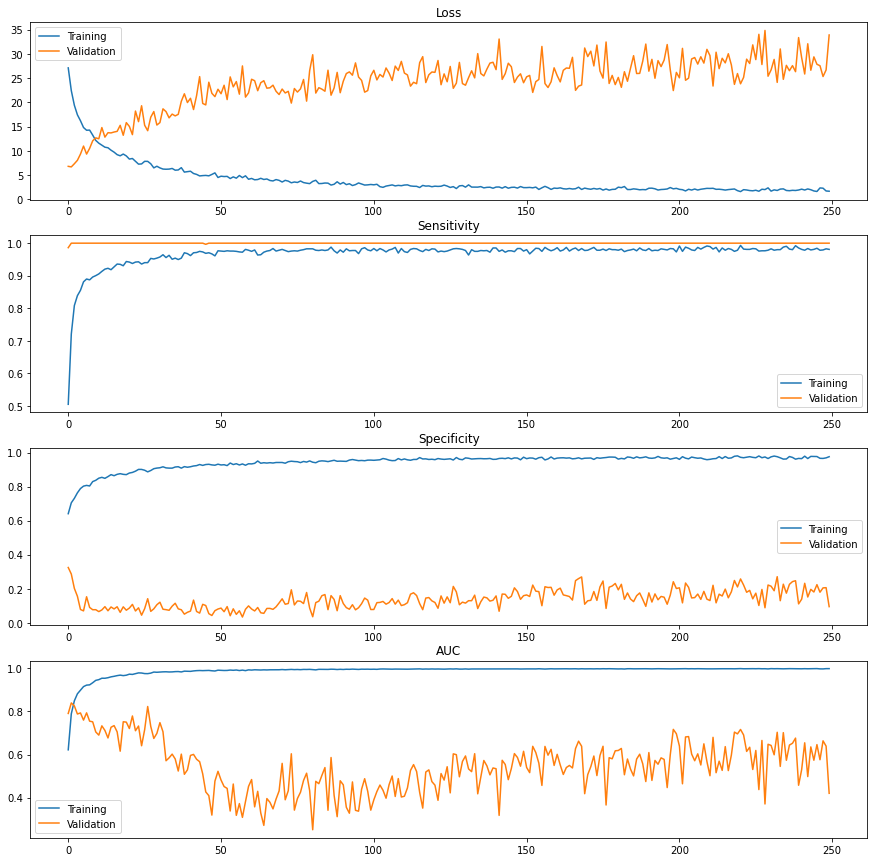

Saving model


In [9]:
if (partitioned):
    save_path = 'models/' + subject + '/part_'
else:
    save_path = 'models/' + subject + '/'
save_path = 'models/test' # comment out this line if you want to save
results = grid_search(EPOCHS, device, weights, train_loader, val_loader, dtype, [k], [f], [d], save_path=save_path, plot_results=True)

In [10]:
from swec_utils import to_numpy

if(std):
    X_test = standardize(X_test, u, s)
# convert dataset to Dataloader
test_dataset = STFTDataset(X_test, Y_test, dtype=dtype)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH)

# retrieve model from save
model = CNN(input_size=next(iter(test_loader))[0].shape[1:], kernel=(5, 5), conv_channels=(5, 5), dropout=0.5)
# if (partitioned):
#     path = './models/' + subject + '/part_CNN_k' + str(k) + '_f' + str(f[0]) + '_' + str(f[0]) + '_d' + str(d).replace('.', '')
# else:
#     path = './models/' + subject + '/CNN_k' + str(k) + '_f' + str(f[0]) + '_' + str(f[0]) + '_d' + str(d).replace('.', '')
path = save_path + 'CNN_k' + str(k) + '_f' + str(f[0]) + '_' + str(f[0]) + '_d' + str(d).replace('.', '')
model.load_state_dict(torch.load(path))

model.to(numpy_to_torch_dtype_dict[dtype])
model.to(device)
model.eval()

pred_list = np.zeros((len(test_loader.dataset), 2))
true_list = np.zeros(len(test_loader.dataset))
i = 0
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)

        output = model(data)
        pred_list[i:i+len(data)] = to_numpy(output)
        true_list[i:i+len(data)] = to_numpy(target)
        i += len(data)

y_true = true_list
y_pred = pred_list

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from swec_utils import evaluate_performance

print(y_true.shape)
print(y_pred.shape)

sensitivity, specificity, roc_auc, f1_score, pr_auc = evaluate_performance(y_pred, y_true)

print("Sensitivity: " + str(sensitivity))
print("Specificity: " + str(specificity))
print("F1 Score: " + str(f1_score))
print("AUC: " + str(roc_auc))
print("PR AUC: " + str(pr_auc))

(12960,)
(12960, 2)
Sensitivity: 0.9916666666666667
Specificity: 0.32009803921568625
F1 Score: 0.14637146371463716
AUC: 0.9239933392338416
PR AUC: 0.4091841975707265


In [12]:
print(X_val[0,:,0])
print(X_val[0,:,-1])
print(X_val[-1,:,0])
print(X_val[-1,:,-1])
print(np.count_nonzero(Y_val == 1))

[[ -4.086 -11.38  -11.19  ...   7.293  27.17   -9.33 ]
 [ -4.953 -18.03  -10.46  ...  36.6   -21.64  -13.05 ]
 [ -5.207  -1.831   4.492 ...  12.195 -24.47   -9.68 ]
 ...
 [  2.582 -54.84   36.06  ...  -7.703   9.83  -10.92 ]
 [ -9.03  -17.58   23.89  ...   0.814   2.707 -10.72 ]
 [  1.361 -11.87   22.08  ...  -7.133  16.22  -13.15 ]]
[[-1.537e-01 -4.294e-04  2.165e-04 ...  2.190e-03  8.283e-04 -1.598e-02]
 [-1.490e-01 -1.794e-05 -5.741e-04 ... -3.210e-03 -1.633e-04 -1.310e-01]
 [ 7.324e-02 -4.356e-04  2.078e-04 ... -7.076e-04  2.092e-05 -8.612e-02]
 ...
 [ 4.983e-01  1.581e-03 -1.811e-03 ... -1.650e-03 -5.226e-04  2.485e-01]
 [ 1.433e-01 -1.398e-03 -5.078e-04 ... -5.279e-04 -5.913e-04  2.542e-01]
 [ 9.564e-02  6.313e-04 -3.712e-04 ...  1.158e-03 -3.183e-04 -3.479e-02]]
[[ -25.8    -76.8    -18.16  ...   99.44    61.5    -28.89 ]
 [ -14.92   -12.68   -54.53  ...   71.2     70.56   -53.4  ]
 [  -8.3    -14.734    3.19  ...   82.      35.38   -71.75 ]
 ...
 [  18.23   -26.33   -30.39  ...

In [13]:
print(X_val[np.where(Y_val == 1)[0][0],:,0])
print(X_val[np.where(Y_val == 1)[0][0],:,-1])

[[ 10.36     9.87     4.617  ...   6.766  -36.7     -4.047 ]
 [  0.6978 -11.78    -0.4624 ... -14.75   -10.39     6.715 ]
 [  3.932   -7.777    5.875  ...  -6.203  -10.74     4.457 ]
 ...
 [  3.422   -2.492    9.67   ...  23.3      7.246  -14.26  ]
 [ -2.652    7.38    -2.467  ...  27.05   -12.12   -13.64  ]
 [ -9.21     6.098   -8.125  ...   7.797  -10.12    -7.227 ]]
[[ 1.034e-01  3.433e-04 -1.975e-04 ... -2.140e-04  3.855e-04 -2.333e-01]
 [ 1.642e-01  4.137e-05  7.620e-04 ...  2.792e-04 -2.446e-04 -1.907e-01]
 [ 1.509e-01 -6.539e-05 -3.936e-04 ...  4.570e-04  2.496e-04 -1.523e-01]
 ...
 [ 1.959e-01 -7.734e-04 -6.461e-04 ...  2.611e-04  3.638e-04  2.212e-01]
 [ 1.329e-01  5.889e-04  1.676e-04 ... -4.251e-04 -8.619e-05  1.630e-01]
 [ 7.603e-03 -7.200e-05  2.685e-04 ... -2.223e-05 -1.715e-04 -1.873e-01]]


In [14]:
best_f1 = 0
best_idx = 0
f1_scores = []
for i in range(len(results)):
    f1 = results[i][3][0]
    f1_scores.append(f1)
    if (f1 > best_f1):
        best_f1 = f1
        best_idx = i

print(best_idx, best_f1)

IndexError: list index out of range

In [ ]:
idxs = np.argsort(f1_scores)

In [ ]:
print(f1_scores[idxs[-1]])
print(f1_scores[idxs[-2]])
print(f1_scores[idxs[-3]])